In [1]:
%run ../confg

In [2]:
"""Script to read in WRF ACINN data
Note: it is a sort of WRF Data, but still different than the WRF_ETH files.

Use salem from Prof. Maussion (https://salem.readthedocs.io/en/stable/) to read it in, had to modify it sometimes

Most important functions:
- read_wrf_fixed_point_and_time() # at fixed point and time, only independent coordinate is the height
- read_wrf_fixed_time() # get a 2D slice if i select afterwards also a certain height
- read_wrf_fixed_point() # get a timeseries with variable height
"""
import metpy.calc as mpcalc
import netCDF4
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from salem import wrftools
from shapely.geometry import Point, Polygon
from xarray.backends.netCDF4_ import NetCDF4DataStore
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

In [3]:
def __open_wrf_dataset_my_version(file, **kwargs):
    """Updated Function from salem, the problem is that our time has no units (so i had to remove the check in the original function)
    Internally used to unstagger, and read in WRF 3D File.

    Wrapper around xarray's open_dataset to make WRF files a bit better.

    This is needed because variables often have not enough georef attrs
    to be understood alone, and datasets tend to loose their attrs with
    operations...

    Parameters
    ----------
    file : str
        the path to the WRF file
    **kwargs : optional
        Additional arguments passed on to ``xarray.open_dataset``.

    Returns
    -------
    an xarray Dataset
    """

    nc = netCDF4.Dataset(file)
    nc.set_auto_mask(False)

    # Change staggered variables to unstaggered ones (did not work on salem)
    for vn, v in nc.variables.items():
        if wrftools.Unstaggerer.can_do(v):
            nc.variables[vn] = wrftools.Unstaggerer(v)

    # Check if we can add diagnostic variables to the pot
    for vn in wrftools.var_classes:
        cl = getattr(wrftools, vn)
        if vn not in nc.variables and cl.can_do(nc):
            nc.variables[vn] = cl(nc)

    # trick xarray with our custom netcdf
    ds = xr.open_dataset(NetCDF4DataStore(nc), **kwargs)

    # remove time dimension to lon lat
    for vn in ['XLONG', 'XLAT']:
        try:
            v = ds[vn].isel(Time=0)
            ds[vn] = xr.DataArray(v.values, dims=['south_north', 'west_east'])
        except (ValueError, KeyError):
            pass

    # add cartesian coords
    ds['west_east'] = ds.salem.grid.x_coord
    ds['south_north'] = ds.salem.grid.y_coord

    # add pyproj string everywhere
    ds.attrs['pyproj_srs'] = ds.salem.grid.proj.srs
    for v in ds.data_vars:
        ds[v].attrs['pyproj_srs'] = ds.salem.grid.proj.srs

    return ds

In [4]:
def salem_example_plots(ds):
    """Make some example plots with salem plotting functions need to have some slice of lat lon
    Could be used in future to plot 2D maps with a certain variable and a certain extent
    """
    hmap = ds.salem.get_map(cmap='topo')

    hmap.set_data(ds['alb'])
    hmap.set_points(station_files_zamg["LOWI"]["lon"], station_files_zamg["LOWI"]["lat"])
    hmap.set_text(station_files_zamg["LOWI"]["lon"], station_files_zamg["LOWI"]["lat"], 'Innsbruck', fontsize=17)
    hmap.visualize()

    psrs = 'epsg:4236'  # http://spatialreference.org/ref/epsg/wgs-84-utm-zone-30n/

    ds.attrs['pyproj_srs'] = psrs

    print(ds["alb"])
    padding = 0.02
    min_lon = 11.3398110103 - padding
    max_lon = 11.4639758751 + padding
    min_lat = 47.2403724414 - padding
    max_lat = 47.321

    box_polygon2 = Polygon(
        [(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat), (min_lon, min_lat)])

    plt.figure()
    ds["alb"].salem.quick_map(interp='linear')


In [5]:
def convert_calc_variables(df_wrf, selected_vars=None):
    """
    Converts and calculates meteorological variables for xarray Dataset for WRF Data

    Parameters:
    - df_wrf: A xarray Dataset, most probably containing the variables 'p' for pressure in Pa
          and 'th' for potential temperature in Kelvin.
    - selected_vars: selected variables

    Returns:
    - A modified xarray Dataset with new variables (depends on the selected variables)

    In total possible are: pressure in hPa, temperature in degrees Celsius,
      relative humidity, dewpoint, and specific humidity, ff and dd for wind
    """

    # Ensure the dataset is ready for MetPy
    if selected_vars is None:
        selected_vars = ['p', 'th', 'q_mixingratio', 'u', 'v',
                         "z"]  # define variables that i want to keep, which also have units in the attrs
    df_quantified = xr.Dataset()

    for var in selected_vars:
        if var in df_wrf and 'units' in df_wrf[var].attrs and df_wrf[var].attrs['units'] not in ['-', '', None]:
            df_quantified[var] = df_wrf[var].metpy.quantify()
        else:
            print(f"Variable '{var}' does not have valid units and will not be quantified.")

    # Convert pressure from Pa to hPa and calculate temperature from potential temperature
    if 'p' in df_quantified and 'th' in df_quantified:
        df_quantified['pressure'] = df_quantified['p'].metpy.convert_units("hPa")
        df_quantified['temperature'] = mpcalc.temperature_from_potential_temperature(df_quantified['pressure'],
                                                                                     df_quantified[
                                                                                         'th']).metpy.convert_units(
            'degC')

    # Calculate relative humidity
    if 'q_mixingratio' in df_quantified and 'pressure' in df_quantified and 'temperature' in df_quantified:
        df_quantified['relative_humidity'] = mpcalc.relative_humidity_from_mixing_ratio(df_quantified['pressure'],
                                                                                        df_quantified['temperature'],
                                                                                        df_quantified[
                                                                                            'q_mixingratio'].metpy.convert_units(
                                                                                            'kg/kg')).metpy.convert_units(
            'percent')

    # Calculate dewpoint from relative humidity
    if 'temperature' in df_quantified and 'relative_humidity' in df_quantified:
        df_quantified['dewpoint'] = mpcalc.dewpoint_from_relative_humidity(df_quantified['temperature'],
                                                                           df_quantified['relative_humidity'])

    # Calculate specific humidity
    if 'pressure' in df_quantified and 'dewpoint' in df_quantified:
        df_quantified['specific_humidity'] = mpcalc.specific_humidity_from_dewpoint(df_quantified['pressure'],
                                                                                    df_quantified[
                                                                                        'dewpoint']).metpy.convert_units(
            'g/kg')

    if "u" in df_quantified and "v" in df_quantified:
        df_quantified["ff"] = mpcalc.wind_speed(df_quantified["u"], df_quantified["v"])
        df_quantified["dd"] = mpcalc.wind_direction(df_quantified["u"], df_quantified["v"], convention="from")

    # Optional: Convert all metpy units back to plain xarray data, removing pint quantities
    df_quantified = df_quantified.metpy.dequantify()

    return df_quantified

In [6]:
def read_wrf_fixed_point_and_time(day: int, hour: int, latitude: float, longitude: float, minute: int):
    """Read in WRF ACINN at a fixed time (hour, day, min) and location (lat, lon)

    :param day: day can be 15 or 16 (October)
    :param hour: can be from 12 to 00 for 15.October to 00 to 12 for 16. October
    :param latitude:
    :param longitude:
    :param minute: can be 00 or 30 (default is 00)
    """

    if day not in [15, 16]:
        raise ValueError("Only October day 15 or 16 is available!")

    day = str(day)

    formatted_hour = f"{hour:02d}"
    if minute not in [0, 30]:
        raise ValueError("Only 0 or 30 min are possibile. Values available only for full hour or half hour")
    formatted_min = f"{minute:02d}"

    date = f"201710{day}"
    my_time = f"{date}T{formatted_hour}{formatted_min}Z"
    filepath2 = f"{wrf_folder}/WRF_ACINN_{date}/WRF_ACINN_20171015T1200Z_CAP02_3D_30min_1km_HCW_{my_time}.nc"

    ds = __open_wrf_dataset_my_version(filepath2)
    # salem_example_plots(ds) # could plot some salem 2D plots
    """ print variables and units
    for var_name, data_array in ds.data_vars.items():
        long_name = data_array.attrs.get('description', 'No long name available')
        units = data_array.attrs.get('units', 'Units not specified')
        print(f"- {var_name}: {long_name}, Units: {units}")
    """

    df = ds.salem.subset(geometry=Point(longitude, latitude),
                         crs='epsg:4236')
    df = df.isel(Time=0, south_north=0, west_east=0)  # select all isel =0
    df = convert_calc_variables(df)

    return df

In [7]:
def read_wrf_fixed_point(latitude: float, longitude: float, start_day=15, end_day=16, variable_list=None,
                         lowest_level=False):
    """Read and merge WRF files across multiple days and times for a specified location. (used for lidar plots)
    It is also possible to define the lowest_level = True, selects only lowest level

    :param lowest_level: Default False, but if True then select only lowest level
    :param variable_list: a variable list to keep only certain variables, if it is NONE, then preselection is done
    :param start_day: Start day (October, can be 15 or 16, default 15).
    :param end_day: End day (October, can be 15 or 16, default 15).
    :param latitude: Latitude of the location.
    :param longitude: Longitude of the location.
    """
    if variable_list is None:
        variable_list = ["u", "v", "z", "th", "time", "p", "q_mixingratio"]

    def generate_datasets():
        for day in range(start_day, end_day + 1):
            date = f"201710{day:02d}"
            day_folder = f"WRF_ACINN_{date}"
            for hour in range(14 if day == 15 else 0, 24 if day == 15 else 13):  # adapted logic
                for minute in [0, 30]:
                    if (hour == 12) & (minute == 30):
                        continue  # skip 12:30 for day 16
                    file_name = f"WRF_ACINN_201710{15:02d}T{12:02d}{0:02d}Z_CAP02_3D_30min_1km_HCW_{date}T{hour:02d}{minute:02d}Z.nc"
                    filepath = f"{wrf_folder}/{day_folder}/{file_name}"

                    ds = __open_wrf_dataset_my_version(filepath)
                    # Directly subset the dataset for the given point and time
                    df = ds.salem.subset(geometry=Point(longitude, latitude), crs='epsg:4236')
                    if lowest_level:
                        df = df.isel(Time=0, south_north=0, west_east=0, bottom_top=0)
                    else:
                        df = df.isel(Time=0, south_north=0, west_east=0)

                    df = df[variable_list]  # define variables
                    yield df

    combined_ds = xr.concat(generate_datasets(), dim='time')

    # assign bottom top as coordinate, and give it the values of z (height) m
    z_values_at_time0 = combined_ds.isel(time=0)['z']
    combined_ds = combined_ds.assign_coords(bottom_top=z_values_at_time0.values)
    combined_ds = combined_ds.rename({"bottom_top": "height"})
    combined_ds = convert_calc_variables(combined_ds, selected_vars=variable_list)
    return combined_ds

In [8]:
def read_wrf_fixed_time(my_time, min_lon, max_lon, min_lat, max_lat, variable_list=None,
                        lowest_level=False):
    """Read and merge WRF files across multiple days and times for a specified location. (used for lidar plots)
    It is also possible to define the lowest_level = True, selects only lowest level

    :param my_time: selected time
    :param min_lon, max_lon, min_lat, max_lat: minimum and maximum latitude and longitude of Box
    :param lowest_level: Default False, but if True then select only lowest level
    :param variable_list: a variable list to keep only certain variables, if it is NONE, then preselection is done

    """
    box_polygon = Polygon(
        [(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat), (min_lon, min_lat)])

    if variable_list is None:
        variable_list = ["u", "v", "z", "th", "p", "alb", "q_mixingratio"]

    time = pd.to_datetime(my_time)
    day = time.day
    hour = time.hour
    minute = time.minute

    file_name = f"WRF_ACINN_201710{15:02d}T{12:02d}{0:02d}Z_CAP02_3D_30min_1km_HCW_201710{day:02d}T{hour:02d}{minute:02d}Z.nc"
    filepath = f"{wrf_folder}/WRF_ACINN_201710{day:02d}/{file_name}"

    df = __open_wrf_dataset_my_version(filepath)
    df = df.salem.subset(geometry=box_polygon, crs='epsg:4236').isel(Time=0)
    if lowest_level:
        df = df.isel(bottom_top=0)  # select lowest level

    df = df[variable_list]
    return df

<xarray.DataArray 'alb' (south_north: 362, west_east: 231)> Size: 334kB
[83622 values with dtype=float32]
Coordinates:
  * west_east    (west_east) float64 2kB -1.07e+05 -1.06e+05 ... 1.23e+05
  * south_north  (south_north) float64 3kB -1.42e+05 -1.41e+05 ... 2.19e+05
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  ALBEDO
    units:        -
    stagger:      
    pyproj_srs:   +proj=lcc +lat_0=47.3000068664551 +lon_0=11.3999996185303 +...


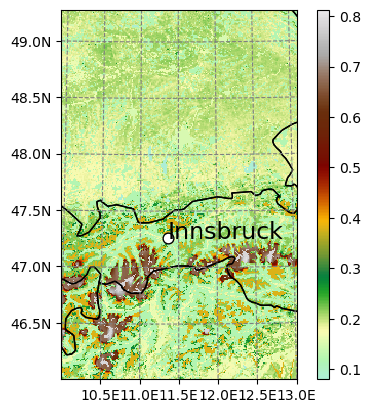

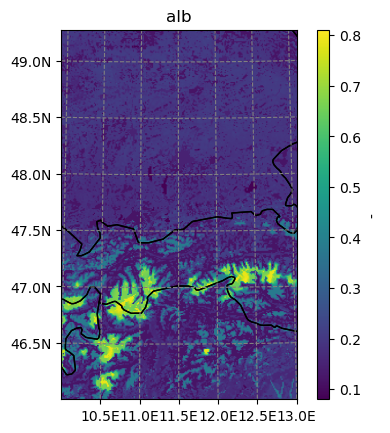

In [10]:
if __name__ == '__main__':
    # df = read_wrf_fixed_point_and_time(day=16, hour=3, latitude=station_files_zamg["IAO"]["lat"],
    #                               longitude=station_files_zamg["IAO"]["lon"], minute=0)

    # df = read_wrf_fixed_point(start_day=15, end_day=15, latitude=station_files_zamg["IAO"]["lat"],
    #                        longitude=station_files_zamg["IAO"]["lon"])

    # print(df)
    # print(read_wrf_fixed_point(longitude=11.3857,
    #                           latitude=47.2640, lowest_level=True))

    ds = read_wrf_fixed_time(my_time="2017-10-15T14:00:00", min_lon=10, max_lon=13, min_lat=46, max_lat=50,
                             lowest_level=True)
    salem_example_plots(ds)
    #plt.show()